<a href="https://colab.research.google.com/github/ashikshafi08/Learning-Fastai/blob/main/Tree_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install aicrowd-cli

%load_ext aicrowd.magic
%aicrowd login

# Downloading the Dataset
!rm -rf data
!mkdir data
%aicrowd ds dl -c tree-segmentation -o data

     |████████████████████████████████| 49 kB 4.5 MB/s 
     |████████████████████████████████| 170 kB 17.2 MB/s 
     |████████████████████████████████| 62 kB 1.0 MB/s 
     |████████████████████████████████| 76 kB 5.0 MB/s 
     |████████████████████████████████| 54 kB 3.4 MB/s 
     |████████████████████████████████| 208 kB 59.5 MB/s 
     |████████████████████████████████| 63 kB 1.5 MB/s 
     |████████████████████████████████| 51 kB 9.5 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.41.1
    Uninstalling tqdm-4.41.1:
      Successfully uninstalled tqdm-4.41.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requ

test.zip:   0%|          | 0.00/316M [00:00<?, ?B/s]

train.zip:   0%|          | 0.00/402M [00:00<?, ?B/s]

In [ ]:
!pip install fastai -q --upgrade 

# Unzipping the data 
!unzip data/train.zip -d data/train > /dev/null
!unzip data/test.zip -d data/test > /dev/null

     |████████████████████████████████| 188 kB 7.6 MB/s 
     |████████████████████████████████| 53 kB 2.7 MB/s 


In [ ]:
from fastai.vision.all import *
from fastai import * 

In [ ]:
# Getting the paths of our images 

train_img_path = 'data/train/image'
train_seg_path = 'data/train/segmentation'

test_img_path = 'data/test/image'

In [ ]:
# Looking to the directory 
import os 
os.listdir(train_img_path)[:10]

['1177.jpg',
 '2726.jpg',
 '3242.jpg',
 '4050.jpg',
 '3993.jpg',
 '4219.jpg',
 '2092.jpg',
 '4663.jpg',
 '1370.jpg',
 '3702.jpg']

In [ ]:
# How the segmentation image path looks like 
os.listdir(train_seg_path)[:4]

['2114.png', '1538.png', '3804.png', '3088.png']

In [ ]:
# Getting the filenames 
train_img_fns = get_image_files(train_img_path)
train_seg_fns = get_image_files(train_seg_path)

In [ ]:
path = 'data/train/'
get_seg = lambda o: path + "segmentation/"+f'{o.stem}.png'
get_img = lambda o: path + "image/"+f'{o.stem}.jpg'

In [ ]:
tree = DataBlock(blocks = (ImageBlock() , ImageBlock()), 
                 get_items = get_image_files , 
                 splitter = RandomSplitter(valid_pct= 0.2), 
                 item_tfms = Resize(460), 
                 get_x = get_img,
                 get_y = get_seg,
                 batch_tfms = [*aug_transforms(size= 224), Normalize.from_stats(*imagenet_stats)])

tree.summary('data/train')

Setting-up type transforms pipelines
Found 10000 items
2 datasets of sizes 8000,2000
Setting up Pipeline: <lambda> -> PILBase.create
Setting up Pipeline: <lambda> -> PILBase.create

Building one sample
  Pipeline: <lambda> -> PILBase.create
    starting from
      data/train/image/1960.jpg
    applying <lambda> gives
      data/train/image/1960.jpg
    applying PILBase.create gives
      PILImage mode=RGB size=512x512
  Pipeline: <lambda> -> PILBase.create
    starting from
      data/train/image/1960.jpg
    applying <lambda> gives
      data/train/segmentation/1960.png
    applying PILBase.create gives
      PILImage mode=RGB size=512x512

Final sample: (PILImage mode=RGB size=512x512, PILImage mode=RGB size=512x512)


Found 10000 items
2 datasets of sizes 8000,2000
Setting up Pipeline: <lambda> -> PILBase.create
Setting up Pipeline: <lambda> -> PILBase.create
Setting up after_item: Pipeline: Resize -- {'size': (460, 460), 'method': 'crop', 'pad_mode': 'reflection', 'resamples': (2, 

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1023: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  /pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:760.)
  ret = func(*args, **kwargs)


In [ ]:
# Building a dataloaders 
dls = tree.dataloaders('data/train' , bs=8)
dls.c = 3

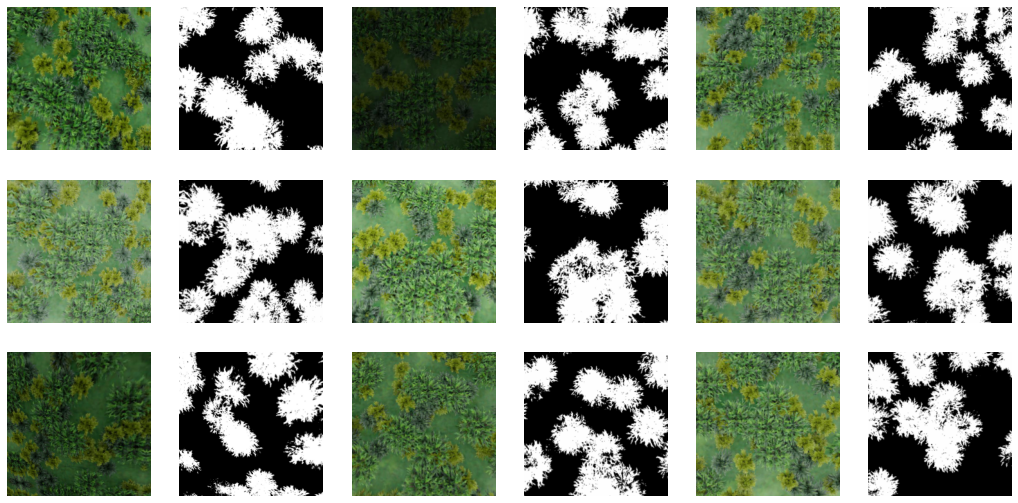

In [ ]:
dls.show_batch()

In [ ]:
# Importing some metrics annd loss function 
opt = ranger
dice = Dice()

In [ ]:
dice

In [ ]:
# Building a learner 
#learn = unet_learner(dls , resnet18 , metrics =[dice, error_rate] , self_attention= True , opt_func= opt)
learn = unet_learner(dls, resnet34 , n_out= dls.c , loss_func= MSELossFlat())


Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [ ]:
learn.fine_tune(5)

epoch,train_loss,valid_loss,time
0,0.485044,0.425912,06:15


epoch,train_loss,valid_loss,time
0,0.371437,0.359278,06:32
1,0.314743,0.295575,06:32
2,0.284675,0.259230,06:31
3,0.255662,0.240902,06:32
4,0.252959,0.233130,06:33


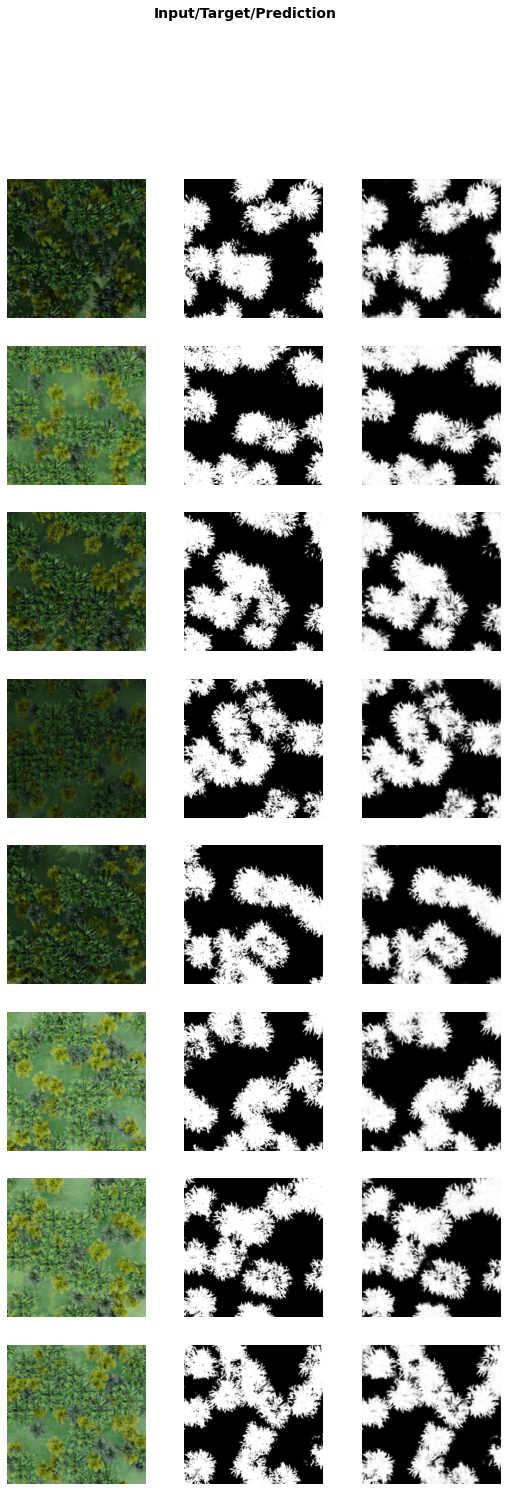

In [ ]:
learn.show_results()

In [ ]:
sample = learn.predict('/content/data/test/image/1004.jpg')

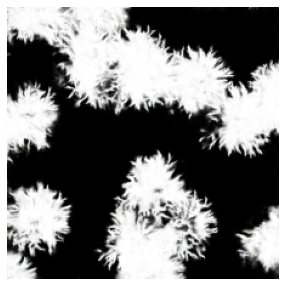

In [ ]:
sample[0].show()

In [ ]:
test_dl = learn.dls.test_dl(get_image_files(test_img_path))
preds = learn.get_preds(dl=test_dl)[0]

In [ ]:
for im in preds:
  print(im.shape)

Streaming output truncated to the last 5000 lines.
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3

In [ ]:
for img in preds:
  img_new = img[0].reshape(224 , 224 , 3)


╭──────────────────────────── Traceback (most recent call last) ────────────────────────────╮
│ /usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882 in run_code  │
│                                                                                           │
│   2879 │   │   │   try:                                                                   │
│   2880 │   │   │   │   self.hooks.pre_run_code_hook()                                     │
│   2881 │   │   │   │   #rprint('Running code', repr(code_obj)) # dbg                      │
│ ❱ 2882 │   │   │   │   exec(code_obj, self.user_global_ns, self.user_ns)                  │
│   2883 │   │   │   finally:                                                               │
│   2884 │   │   │   │   # Reset our crash handler in place                                 │
│   2885 │   │   │   │   sys.excepthook = old_excepthook                                    │
│ <ipython-input-84-17021b57eed9>:2 in <module>                                             │
│                                                                                           │
│ /usr/local/lib/python3.7/dist-packages/fastai/torch_core.py:340 in __torch_function__     │
│                                                                                           │
│   337 │   │   if self.debug and func.__name__ not in ('__str__','__repr__'): print(func,  │
│   338 │   │   convert=False                                                               │
│   339 │   │   if _torch_handled(args, self._opt, func): convert,types = type(self),(torch │
│ ❱ 340 │   │   res = super().__torch_function__(func, types, args=args, kwargs=kwargs)     │
│   341 │   │   if convert: res = convert(res)                                              │
│   342 │   │   if isinstance(res, TensorBase): res.set_meta(self, as_copy=True)            │
│   343 │   │   return res                                                                  │
│                                                                                           │
│ /usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1023 in __torch_function__        │
│                                                                                           │
│   1020 │   │   │   return NotImplemented                                                  │
│   1021 │   │                                                                              │
│   1022 │   │   with _C.DisableTorchFunction():                                            │
│ ❱ 1023 │   │   │   ret = func(*args, **kwargs)                                            │
│   1024 │   │   │   return _convert(ret, cls)                                              │
│   1025 │                                                                                  │
│   1026 │   __module__ = 'torch'                                                           │
╰───────────────────────────────────────────────────────────────────────────────────────────╯
RuntimeError: shape '[224, 224, 3]' is invalid for input of size 50176

In [ ]:
preds[0].reshape(224 , 224 , 3).shape

torch.Size([224, 224, 3])

In [ ]:
def store_preds(predictions):

  for n , img in enumerate(predictions):
    img = img[0]
    img = img.swapaxes(0,2).numpy()

    img = Image.fromarray(img.astype(np.uint8))
    
    img.save(os.path.join('segmentation' , f'{n}.png'))



In [ ]:
store_preds(preds)

╭──────────────────────────── Traceback (most recent call last) ────────────────────────────╮
│ /usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882 in run_code  │
│                                                                                           │
│   2879 │   │   │   try:                                                                   │
│   2880 │   │   │   │   self.hooks.pre_run_code_hook()                                     │
│   2881 │   │   │   │   #rprint('Running code', repr(code_obj)) # dbg                      │
│ ❱ 2882 │   │   │   │   exec(code_obj, self.user_global_ns, self.user_ns)                  │
│   2883 │   │   │   finally:                                                               │
│   2884 │   │   │   │   # Reset our crash handler in place                                 │
│   2885 │   │   │   │   sys.excepthook = old_excepthook                                    │
│ <ipython-input-61-37e97bfb68c2>:1 in <module>                                             │
│ <ipython-input-60-7fa0c5e9f995>:5 in store_preds                                          │
│                                                                                           │
│ /usr/local/lib/python3.7/dist-packages/fastai/torch_core.py:340 in __torch_function__     │
│                                                                                           │
│   337 │   │   if self.debug and func.__name__ not in ('__str__','__repr__'): print(func,  │
│   338 │   │   convert=False                                                               │
│   339 │   │   if _torch_handled(args, self._opt, func): convert,types = type(self),(torch │
│ ❱ 340 │   │   res = super().__torch_function__(func, types, args=args, kwargs=kwargs)     │
│   341 │   │   if convert: res = convert(res)                                              │
│   342 │   │   if isinstance(res, TensorBase): res.set_meta(self, as_copy=True)            │
│   343 │   │   return res                                                                  │
│                                                                                           │
│ /usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1023 in __torch_function__        │
│                                                                                           │
│   1020 │   │   │   return NotImplemented                                                  │
│   1021 │   │                                                                              │
│   1022 │   │   with _C.DisableTorchFunction():                                            │
│ ❱ 1023 │   │   │   ret = func(*args, **kwargs)                                            │
│   1024 │   │   │   return _convert(ret, cls)                                              │
│   1025 │                                                                                  │
│   1026 │   __module__ = 'torch'                                                           │
╰───────────────────────────────────────────────────────────────────────────────────────────╯
IndexError: Dimension out of range (expected to be in range of [-2, 1], but got 2)

In [ ]:
im_s = im.swapaxes(0,2).numpy()
im_s.dtype

dtype('float32')

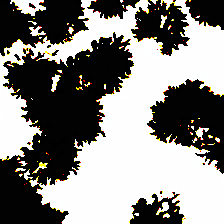

In [ ]:
im_g = Image.fromarray(im_s.astype(np.uint8))
im_g

In [ ]:
im_g.save(os.path.join('sample_data' , f'{38}.png'))